<a href="https://colab.research.google.com/github/tali9943/DEEP-LEARNING-FOR-NATURAL-LANGUAGE-PROCESSING/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# load google drive to see the files in google drive
# drive.mount('/content/drive')

In [ ]:
train_csv_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_train.csv'
test_csv_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_test.csv'
augmented_csv_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_augmented.csv'

In [ ]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
augmented_df = pd.read_csv(augmented_csv_path)

In [ ]:
def plot_panoramic_words(df):
  df['text_len'] = [len(text.split()) for text in df['comment_text']]

  plt.figure(figsize=(30, 5))
  ax = sns.countplot(x='text_len', hue='text_len', data=df[df['text_len'] <= 10], palette='mako', legend=False)
  plt.title('Count of tweets with less than 10 words', fontsize=20)
  plt.yticks([])
  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
  plt.ylabel('Count')
  plt.xlabel('Tweet Length')
  plt.show()

  print((df.sort_values(by=['text_len'], ascending=False))['comment_text'])

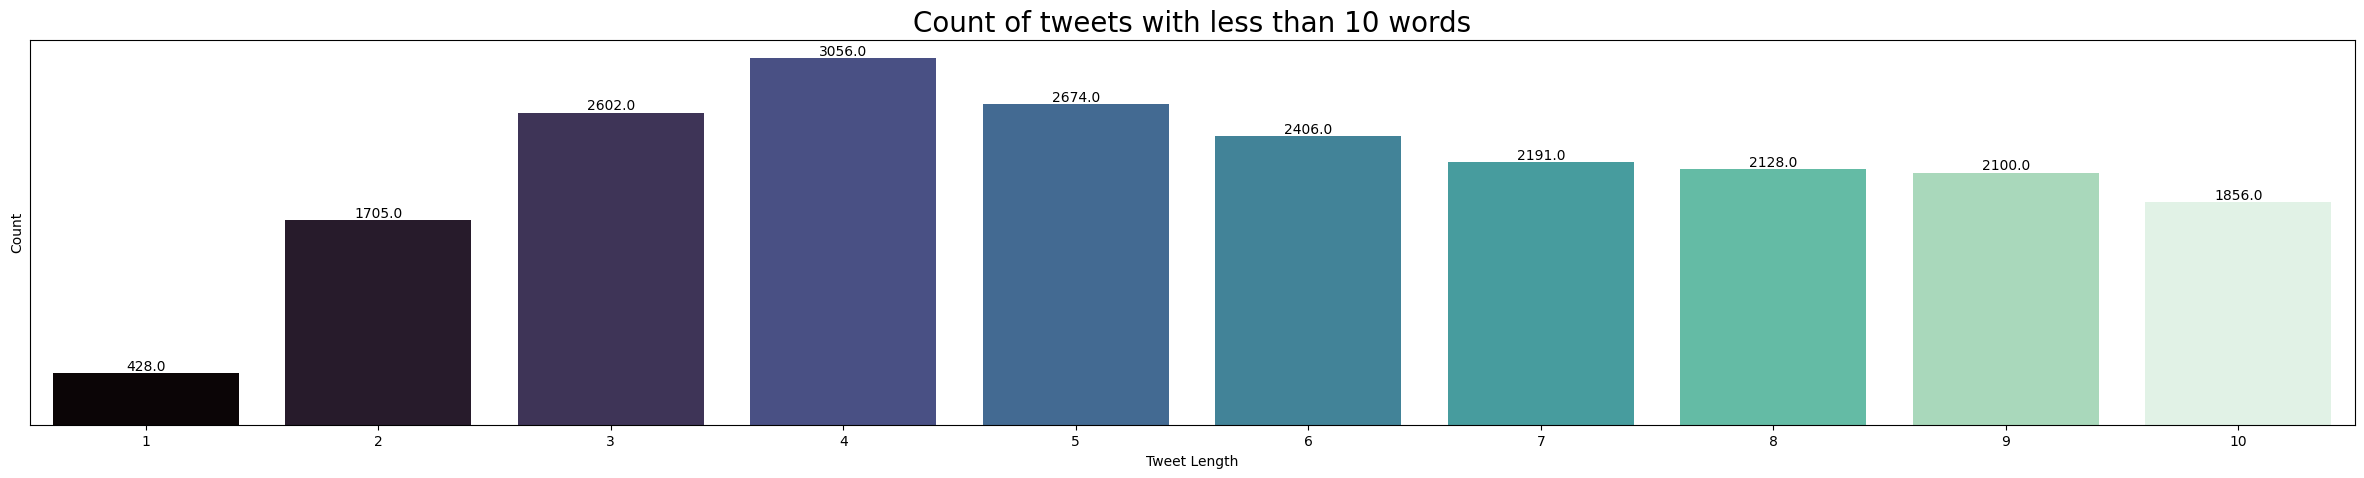

14941    c e f u c k e r c e f u c k e r c e f u c k e ...
11549    gay gay gay gay gay gay gay gay gay gay gay ga...
11621    omfg wtf omfg wtf omfg wtf omfg wtf omfg wtf o...
12010    r e g r n g k r e l j b c n c e r n e v e r u ...
60591    boob boob boob boob boob boob boob boob boob b...
                               ...                        
57410                                                didnt
42442                                            khribisha
7549                                                   cri
42433                                               inform
7508                                                    uh
Name: comment_text, Length: 63025, dtype: object


In [ ]:
plot_panoramic_words(test_df)

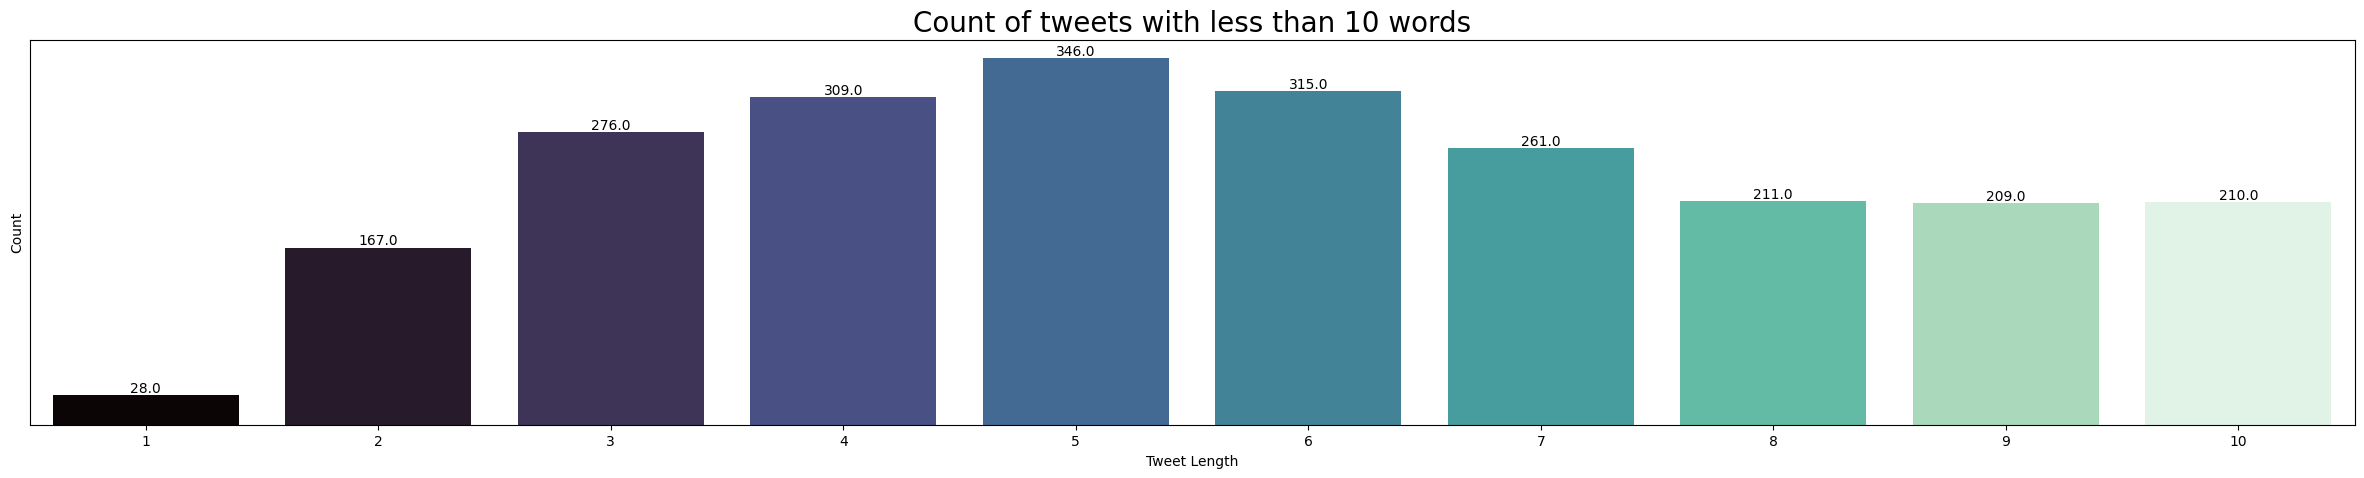

950     cerdo cerdo de cerdo cerdo cerdo cerdo cerdo c...
480     robert ullmann chupa dick robert ullmann chupa...
1858    sida sida sida aid aid aid aidsaid aid aid aid...
1048    eat shit die dog as nigga eat shit die dog as ...
374     damn twat soldier posit artist band group song...
                              ...                        
2933                                                 hate
3716                                                  pig
1616                                           commission
145     uluckkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
14                                                 believ
Name: comment_text, Length: 4502, dtype: object


In [ ]:
plot_panoramic_words(augmented_df)

In [ ]:
def plot_labels_conut(df):
    df = df[['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']]

    # Calculate the count of 1's in each column
    counts = df.sum()

    # Get colors from mako palette
    colors = sns.color_palette("mako", len(counts))

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.index, counts.values, color=colors)
    plt.title('Count of 1s in each column')
    plt.xlabel('Columns')
    plt.ylabel('Count of 1s')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding color legend
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.tight_layout()
    plt.show()

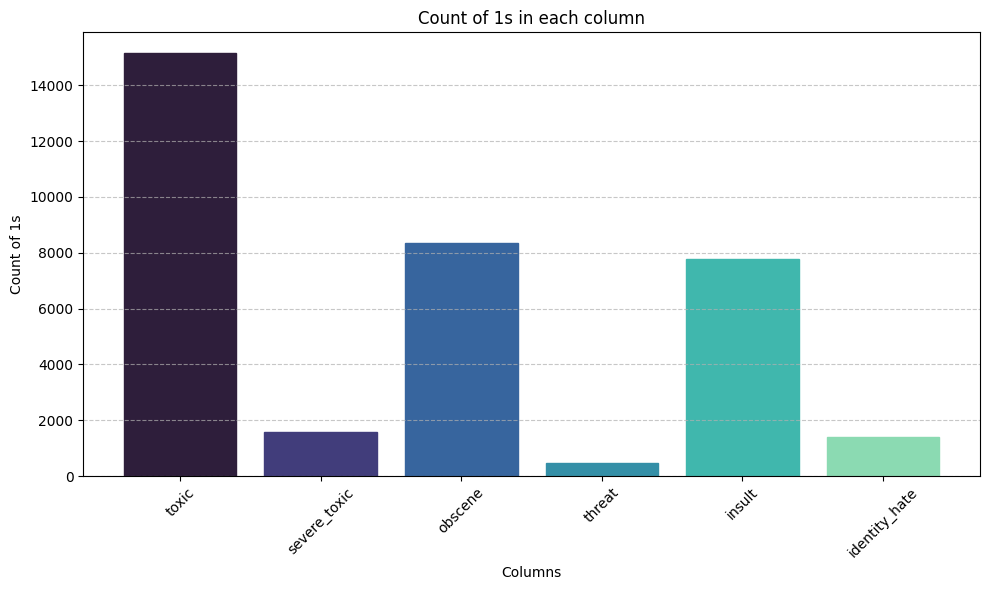

In [ ]:
plot_labels_conut(train_df)

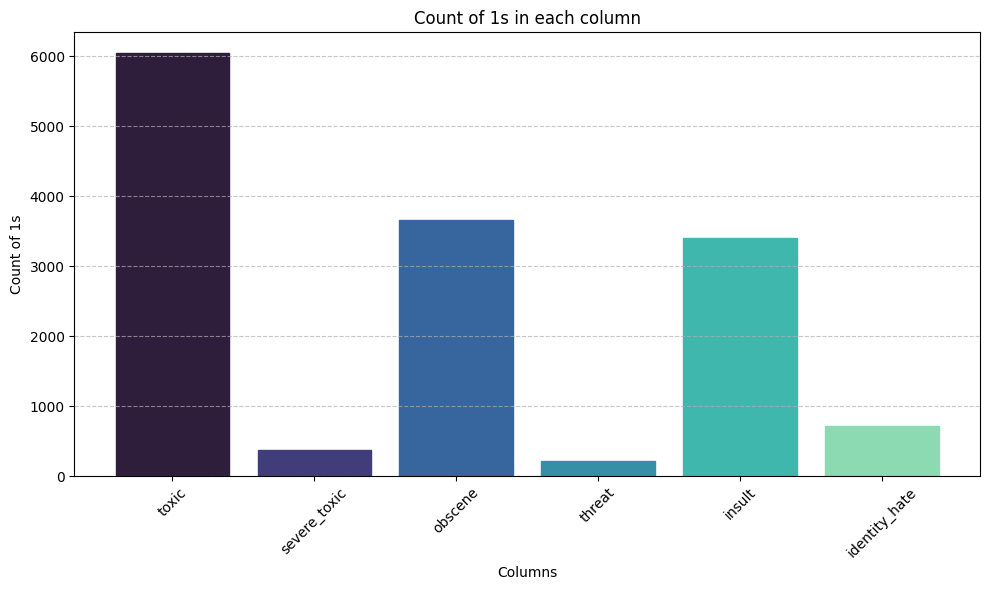

In [ ]:
plot_labels_conut(test_df)

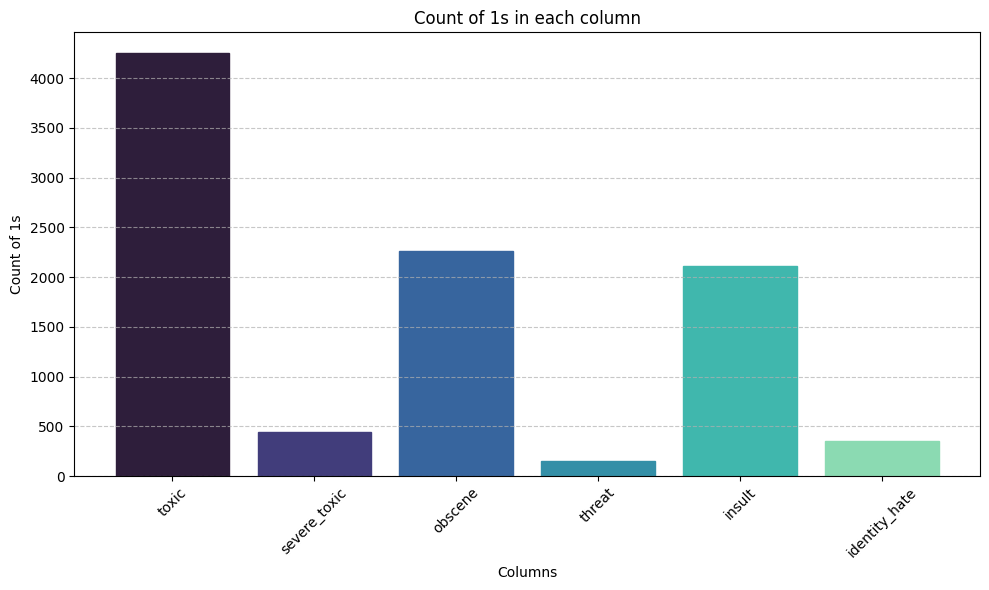

In [ ]:
plot_labels_conut(augmented_df)

<h2> Bert Transformation

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torch.utils.data import Dataset

In [ ]:
n = 100

train_df = train_df.sample(n=n)
test_df = test_df.sample(n=n)
augmented_df = augmented_df.sample(n=round(n/10))

In [ ]:
test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_len
61042,11d1f61a8d6ccc20,mwhahaha fuck bast go leav wikipedia,1,0,1,0,1,0,6
8660,162891dd06ce1954,fair enough ill copi quot respons see point ma...,0,0,0,0,0,0,274
51943,d6a5250a3f1f3451,plant dont retina ganglion cell paragraph delet,0,0,0,0,0,0,7
16626,4e393061421d3edd,welcom fresh eye didnt add discus well talk ma...,0,0,0,0,0,0,20
11501,d513b720f2672bbc,submiss afc pravda record accept pravda record...,0,0,0,0,0,0,50
...,...,...,...,...,...,...,...,...,...
9721,11a56d3218212634,nyc infobox seem like get hang infobox note co...,0,0,0,0,0,0,140
45500,a1fba2fc07460490,ok sound good let see figur offici notic templ...,0,0,0,0,0,0,39
32496,0f18045182e8a52f,ye problem selfidentifi realli come wouldnt ro...,0,0,0,0,0,0,63
61670,324efa2c20fa1a48,februari 2008 utc well look like basic vista s...,0,0,0,0,0,0,13


In [ ]:
X_train = train_df['comment_text'].values
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_test = test_df['comment_text'].values
y_test = test_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_augmented = augmented_df['comment_text'].values
y_augmented = augmented_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [ ]:
train_texts = np.concatenate((X_train, X_augmented), axis=0)
train_labels = np.concatenate((y_train, y_augmented), axis=0)

In [ ]:
# Load the tokenizer and BERT's pre-trained model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Tokenise texts and convert to tensors
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Creating tensors for labels
train_labels = torch.tensor(train_labels, dtype=torch.float32)

# Creation of DataLoader to manage data during training and validation
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)

# Creation of DataLoader to manage data during training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# parameters
optimizer = AdamW(model_bert.parameters(), lr=2e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)

# training model
num_epochs = 3
for epoch in range(num_epochs):

    # Training phase
    model_bert.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

# save the model
model_bert.save_pretrained("bert_sequence_classification_trained")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

In [ ]:
def get_emb_cls_function_trained(df, column_name, model):

    sentences = df[column_name].tolist()

    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True,  max_length=256)

    with torch.no_grad():
        # Ottenere l'output del modello
        outputs = model.bert(**inputs)

    last_hidden_state = outputs.last_hidden_state

    embeddings_words = last_hidden_state[:, 1:-1, :]   #(ignora [CLS] e [SEP])
    embedding_cls = last_hidden_state[:, 0, :]

    return embeddings_words, embedding_cls


# Tokenizzazione del testo
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Caricare il modello addestrato
model_bert = BertForSequenceClassification.from_pretrained('bert_sequence_classification_trained')

In [ ]:
train_df , val_df = train_test_split(train_df, test_size=0.2, random_state=42)

X_val = val_df['comment_text'].values
y_val = val_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

val_df.shape

(20, 8)

In [ ]:
train_df = pd.concat((train_df, augmented_df), axis=0)

X_train = train_df['comment_text'].values
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

train_df.shape

(90, 9)

In [ ]:
embeddings_words_train, embedding_cls_train = get_emb_cls_function_trained(train_df, "comment_text", model_bert)
embeddings_words_test, embedding_cls_test = get_emb_cls_function_trained(test_df, "comment_text", model_bert)
embeddings_words_val, embedding_cls_val = get_emb_cls_function_trained(val_df, "comment_text", model_bert)

print("Shape of BERT embeddings - train:", embeddings_words_train.shape)
print("Shape of CLS embeddings - train:", embedding_cls_train.shape)
print("Shape of BERT embeddings - test:", embeddings_words_test.shape)
print("Shape of CLS embeddings - test:", embedding_cls_test.shape)
print("Shape of BERT embeddings - validation:", embeddings_words_val.shape)
print("Shape of CLS embeddings - validation:", embedding_cls_val.shape)

Shape of BERT embeddings - train: torch.Size([90, 254, 768])
Shape of CLS embeddings - train: torch.Size([90, 768])
Shape of BERT embeddings - test: torch.Size([100, 254, 768])
Shape of CLS embeddings - test: torch.Size([100, 768])
Shape of BERT embeddings - validation: torch.Size([20, 239, 768])
Shape of CLS embeddings - validation: torch.Size([20, 768])


<h2> Training Phase

In [ ]:
import torch
import torch.nn as nn
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CustomDatasetForCLSToken(Dataset):
    def __init__(self, data, targets, cls_tokens):
        self.data = data
        self.targets = targets
        self.cls_tokens = cls_tokens

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        cls_token = self.cls_tokens[idx]

        return sample, target, cls_token

In [ ]:
custom_train_dataset = CustomDatasetForCLSToken(embeddings_words_train, y_train, embedding_cls_train)
custom_val_dataset = CustomDatasetForCLSToken(embeddings_words_val, y_val, embedding_cls_val)
custom_test_dataset = CustomDatasetForCLSToken(embeddings_words_test, y_test, embedding_cls_test)


In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        energy = torch.tanh(self.attn(lstm_output))
        attention_weights = torch.softmax(energy, dim=1)
        return attention_weights

class SentimentClassifierWithSoftAttention(nn.Module):
    def __init__(
        self,
        embedding_dim=768,
        hidden_dim=256,
        output_dim=6,
        n_layers=1,
        bidirectional=True,
        dropout=0.0,
        rnn_type = 'LSTM',
    ):
        super().__init__()

        # Attention mechanism
        self.attention = Attention(hidden_dim * 2 if bidirectional else hidden_dim)

        # RNN layer

        if rnn_type == 'LSTM':
          print('Built using LSTM')
          self.rnn = nn.LSTM(
              embedding_dim,
              hidden_dim,
              num_layers=n_layers,
              bidirectional=bidirectional,
              dropout=dropout,
              batch_first=True,
          )
        elif rnn_type == 'GRU':
          print('Built using GRU')
          self.rnn = nn.GRU(
              embedding_dim,
              hidden_dim,
              num_layers=n_layers,
              bidirectional=bidirectional,
              dropout=dropout,
              batch_first=True,
          )
        else:
          raise ValueError("Choose a valid RNN type: LSTM or GRU")

        # Dense layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

        # Dense layer CLS
        self.fc_cls = nn.Sequential(
            nn.Linear(hidden_dim * 5, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

        # Activation function
        self.act = nn.ReLU()

    def forward(self, embedded):

        weighted_sum = self.prepare_data(embedded)

        # Fully connected layer
        dense_outputs = self.fc(weighted_sum)

        # Final activation function
        outputs = self.act(dense_outputs)

        return outputs

    def forward_with_cls(self, embedded, cls_token):

        # Sum across the sequence dimension
        weighted_sum = self.prepare_data(embedded)

        # Concatenate cls_token with the weighted_sum
        cls_token = cls_token.squeeze(1)  # Add a dimension to match the shape of weighted_sum
        weighted_sum_with_cls = torch.cat((weighted_sum, cls_token), dim=1)

        # Fully connected layer
        dense_outputs = self.fc_cls(weighted_sum_with_cls)

        # Final activation function
        outputs = self.act(dense_outputs)

        return outputs

    # Prepare data
    def prepare_data(self, embedded):
        if len(embedded.shape) != 3:
          raise ValueError("Input shape must be 3D: (batch_size, seq_len, embedding_dim)")

        # LSTM expects 3D input: (batch_size, seq_len, input_size)
        lstm_output, _ = self.rnn(embedded)

        attention_weights = self.attention(lstm_output)

        # Replicate attention weights along the second dimension
        attention_weights = attention_weights.expand(-1, lstm_output.size(1), -1)

        # Apply attention weights to LSTM output
        weighted = lstm_output * attention_weights

        # Sum across the sequence dimension
        weighted_sum = weighted.sum(dim=1)

        return weighted_sum

In [ ]:
def calculate_metrics(predictions, targets):
    num_classes = predictions.shape[1]  # Assuming predictions and targets are numpy arrays

    # Initialize dictionaries to store metrics for each class
    class_metrics = {i: {'true_positives': 0, 'true_negatives': 0, 'false_positives': 0, 'false_negatives': 0} for i in range(num_classes)}

    # Calculate metrics for each class
    for i in range(num_classes):
        for pred, target in zip(predictions[:, i], targets[:, i]):
            if pred == 1 and target == 1:
                class_metrics[i]['true_positives'] += 1
            elif pred == 0 and target == 0:
                class_metrics[i]['true_negatives'] += 1
            elif pred == 1 and target == 0:
                class_metrics[i]['false_positives'] += 1
            elif pred == 0 and target == 1:
                class_metrics[i]['false_negatives'] += 1



    return pd.DataFrame(class_metrics).transpose()

def calculate_accuracy(metrics):
    return (metrics['true_positives'].sum()+metrics['true_negatives'].sum())/metrics.sum().sum()

def calculate_precision(metrics):

    if (metrics['true_positives'].sum() + metrics['false_positives'].sum()) >0 :
      return (metrics['true_positives'].sum())/(metrics['true_positives'].sum() + metrics['false_positives'].sum())
    else: return 0

def calculate_recall(metrics):

    if (metrics['true_positives'].sum() + metrics['false_negatives'].sum()) >0 :
      return (metrics['true_positives'].sum())/(metrics['true_positives'].sum() + metrics['false_negatives'].sum())
    else: return 0

In [ ]:
def class_report(predictions, targets):
    label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    results = classification_report(targets, predictions, target_names=label_names, zero_division=0)
    print(results)

# Parameters

In [ ]:
# Set hyperparameters
num_epochs = 10
learning_rate = 0.001
batch_size = 32

# Define loss function
criterion = nn.MSELoss() #nn.CrossEntropyLoss()

# Define train and validation dataloaders
train_loader = DataLoader(custom_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(custom_val_dataset, batch_size=batch_size, shuffle=True)

# Training method without cls

In [ ]:
def train_model(model_rnn, optimizer, train_loader, val_loader):
  # Training loop
  num_labels = 6
  best_val_loss = float('inf')
  patience = 5  # Number of epochs to wait before stopping if no improvement
  early_stopping_counter = 0

  # Lists to store training and validation metrics across epochs
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  true_num_epochs = 0
  train_precision = []
  val_precision = []
  train_recall = []
  val_recall = []

  best_model_path = 'best_model_LSTM.pth'


  for epoch in range(num_epochs):
      model_rnn.train()
      epoch_loss = 0.0
      correct_train = [0] * num_labels
      total_train = [0] * num_labels
      true_num_epochs = true_num_epochs + 1
      predicted_embeddings =  []
      target_embeddings = []

      for batch_idx, (data, targets, _) in enumerate(train_loader):
          data, targets= data.to(device), targets.to(device)
          optimizer.zero_grad()

          # Forward pass
          outputs = model_rnn.forward(data.to(dtype=torch.float32))

          # Compute loss
          loss = criterion(outputs, targets.to(dtype=torch.float32))

          # Backward pass
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

          mask = outputs >= 0.5
          predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
          predicted_embeddings += [predicted]
          target_embeddings += [targets.to(dtype=torch.float32)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_train_accuracy = calculate_accuracy(metrics)
      overall_train_precision = calculate_precision(metrics)
      overall_train_recall = calculate_recall(metrics)

      report = class_report(target_embeddings_np, predicted_embeddings_np)
      print("----")
      print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.5f}, Training Accuracy: {overall_train_accuracy:.2f}")
      report
      print("")

      # Validation loop
      model_rnn.eval()
      val_loss = 0.0
      correct_val = [0] * num_labels
      total_val = [0] * num_labels
      predicted_embeddings =  []
      target_embeddings = []
      with torch.no_grad():
          for data, targets, _ in val_loader:
              data, targets = data.to(device), targets.to(device)
              #cls_tokens = cls_tokens.view(cls_tokens.shape[0], 1, cls_tokens.shape[1])

              outputs = model_rnn.forward(data.to(dtype=torch.float32))
              loss = criterion(outputs, targets.to(dtype=torch.float32))
              val_loss += loss.item()

              # Calculate accuracy for each label
              mask = outputs >= 0.5

              # Set values to 1 where mask is True, and to 0 where mask is False
              predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
              predicted_embeddings += [predicted]
              target_embeddings += [targets.to(dtype=torch.float32)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_val_accuracy = calculate_accuracy(metrics)
      overall_val_precision = calculate_precision(metrics)
      overall_val_recall = calculate_recall(metrics)


      report = class_report(target_embeddings_np, predicted_embeddings_np)
      print(f"Validation Loss: {val_loss / len(val_loader):.5f}, Validation Accuracy: {overall_val_accuracy:.2f}")
      report
      print("----")

      # Append metrics to lists
      train_losses.append(epoch_loss / len(train_loader))
      val_losses.append(val_loss / len(val_loader))
      train_accuracies.append(overall_train_accuracy)
      val_accuracies.append(overall_val_accuracy)
      train_precision.append(overall_train_precision)
      val_precision.append(overall_val_precision)
      train_recall.append(overall_train_recall)
      val_recall.append(overall_val_recall)

      # Check for early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          early_stopping_counter = 0
          # Save the best model
          torch.save(model_rnn.state_dict(), best_model_path)
      else:
          early_stopping_counter += 1
          if early_stopping_counter >= patience:
              print("Validation loss hasn't improved in the last", patience, "epochs. Stopping training.")
              break

  # Plotting
  epochs = range(1, true_num_epochs + 1)

  # Creazione di una figura e un insieme di sottoplot
  fig, axs = plt.subplots(2, 2, figsize=(10, 6))

  # Disposizione delle immagini

  axs[0, 0].plot(epochs, train_losses, label='Training Loss')
  axs[0, 0].plot(epochs, val_losses, label='Validation Loss')
  axs[0, 0].set_title('Training and Validation Loss')

  axs[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
  axs[0, 1].plot(epochs, val_accuracies, label='Validation Accuracy')
  axs[0, 1].set_title('Training and Validation Accuracy')

  axs[1, 0].plot(epochs, train_precision, label='Training Precision')
  axs[1, 0].plot(epochs, val_precision, label='Validation Precision')
  axs[1, 0].set_title('Training and Validation Precision')

  axs[1, 1].plot(epochs, train_recall, label='Training Recall')
  axs[1, 1].plot(epochs, val_recall, label='Validation Recall')
  axs[1, 1].set_title('Training and Validation Recall')

  # Aggiustamento del layout per evitare sovrapposizioni
  plt.tight_layout()

  # Mostra il grafico
  plt.show()


  return model_rnn

LSTM

Built using LSTM
               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00         0
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.48      0.41      0.44        32
       threat       0.00      0.00      0.00         0
       insult       0.00      0.00      0.00         0
identity_hate       0.00      0.00      0.00         0

    micro avg       0.12      0.41      0.19        32
    macro avg       0.08      0.07      0.07        32
 weighted avg       0.48      0.41      0.44        32
  samples avg       0.05      0.14      0.08        32

----
Epoch 1, Loss: 0.17924, Training Accuracy: 0.79

               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00         0
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.00      0.00      0.00         0
       threat       0.00      0.00      0.00         0
       insult       0.00      0.00      0.00 

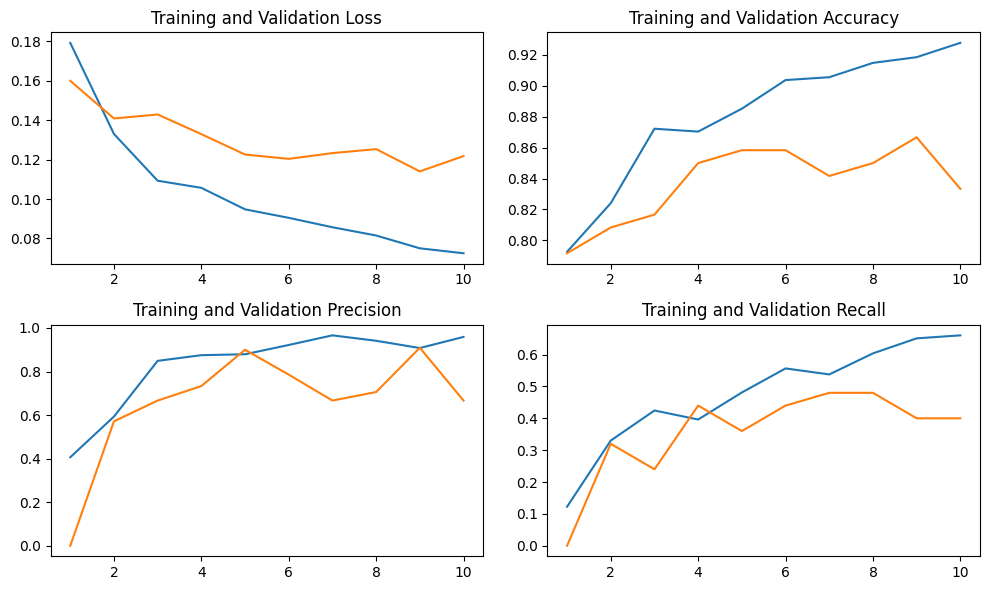

In [ ]:
# Initialize the model
model_rnn_lstm = SentimentClassifierWithSoftAttention(rnn_type='LSTM').to(device)



# Define optimizer and loss function
optimizer = optim.Adam(model_rnn_lstm.parameters(), lr=learning_rate)

model_rnn_lstm = train_model(model_rnn_lstm, optimizer, train_loader, val_loader)

GRU

Built using GRU
               precision    recall  f1-score   support

        toxic       0.62      0.59      0.60        44
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.00      0.00      0.00         0
       threat       0.00      0.00      0.00         0
       insult       0.48      0.38      0.42        32
identity_hate       0.00      0.00      0.00         0

    micro avg       0.36      0.50      0.42        76
    macro avg       0.18      0.16      0.17        76
 weighted avg       0.56      0.50      0.53        76
  samples avg       0.19      0.26      0.20        76

----
Epoch 1, Loss: 0.17745, Training Accuracy: 0.80

               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00         0
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.00      0.00      0.00         0
       threat       0.00      0.00      0.00         0
       insult       0.00      0.00      0.00  

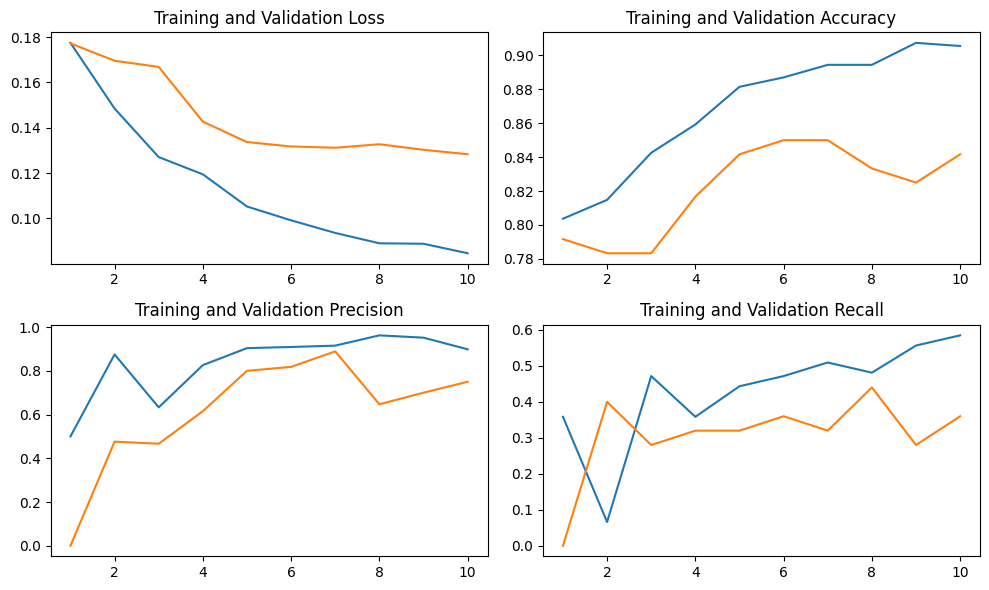

In [ ]:
# Initialize the model
model_rnn_gru = SentimentClassifierWithSoftAttention(rnn_type='GRU').to(device)



# Define optimizer and loss function
optimizer = optim.Adam(model_rnn_gru.parameters(), lr=learning_rate)

model_rnn_gru = train_model(model_rnn_gru, optimizer, train_loader, val_loader)

# Training method with cls

In [ ]:
def train_model_cls(model_rnn, optimizer, train_loader, val_loader):
  # Training loop
  num_labels = 6
  best_val_loss = float('inf')
  patience = 5  # Number of epochs to wait before stopping if no improvement
  early_stopping_counter = 0

  # Lists to store training and validation metrics across epochs
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  train_precision = []
  val_precision = []
  train_recall = []
  val_recall = []
  true_num_epochs = 0

  best_model_path = 'best_model_LSTM.pth'


  for epoch in range(num_epochs):
      model_rnn.train()
      epoch_loss = 0.0
      correct_train = [0] * num_labels
      total_train = [0] * num_labels
      true_num_epochs = true_num_epochs + 1
      predicted_embeddings =  []
      target_embeddings = []

      for batch_idx, (data, targets, cls) in enumerate(train_loader):
          data, targets, cls = data.to(device), targets.to(device), cls.to(device)
          cls_tokens = cls.view(cls.shape[0], 1, cls.shape[1])
          optimizer.zero_grad()

          # Forward pass
          outputs = model_rnn.forward_with_cls(data.to(dtype=torch.float32), cls_tokens.to(dtype=torch.float32))

          # Compute loss
          loss = criterion(outputs, targets.to(dtype=torch.float32))

          # Backward pass
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

          mask = outputs >= 0.5
          predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
          predicted_embeddings += [predicted]
          target_embeddings += [targets.to(dtype=torch.float32)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_train_accuracy = calculate_accuracy(metrics)
      overall_train_precision = calculate_precision(metrics)
      overall_train_recall = calculate_recall(metrics)

      print("----")
      print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.5f}, Training Accuracy: {overall_train_accuracy:.2f}")
      class_report(target_embeddings_np, predicted_embeddings_np)
      print("")

      # Validation loop
      model_rnn.eval()
      val_loss = 0.0
      correct_val = [0] * num_labels
      total_val = [0] * num_labels
      predicted_embeddings =  []
      target_embeddings = []
      with torch.no_grad():
          for data, targets, cls in val_loader:
              data, targets, cls = data.to(device), targets.to(device), cls.to(device)
              cls_tokens = cls.view(cls.shape[0], 1, cls.shape[1])

              outputs = model_rnn.forward_with_cls(data.to(dtype=torch.float32), cls_tokens.to(dtype=torch.float32))
              loss = criterion(outputs, targets.to(dtype=torch.float32))
              val_loss += loss.item()

              # Calculate accuracy for each label
              mask = outputs >= 0.5

              # Set values to 1 where mask is True, and to 0 where mask is False
              predicted = torch.where(mask, torch.tensor(1.0), torch.tensor(0.0))
              predicted_embeddings += [predicted]
              target_embeddings += [targets.to(dtype=torch.float32)]


      predicted_embeddings_np = torch.cat(predicted_embeddings, dim=0).cpu().numpy()
      target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

      metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
      overall_val_accuracy = calculate_accuracy(metrics)
      overall_val_precision = calculate_precision(metrics)
      overall_val_recall = calculate_recall(metrics)

      print(f"Validation Loss: {val_loss / len(val_loader):.5f}, Validation Accuracy: {overall_val_accuracy:.2f}")
      class_report(target_embeddings_np, predicted_embeddings_np)
      print("----")

      # Append metrics to lists
      train_losses.append(epoch_loss / len(train_loader))
      val_losses.append(val_loss / len(val_loader))
      train_accuracies.append(overall_train_accuracy)
      val_accuracies.append(overall_val_accuracy)
      train_precision.append(overall_train_precision)
      val_precision.append(overall_val_precision)
      train_recall.append(overall_train_recall)
      val_recall.append(overall_val_recall)

      # Check for early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          early_stopping_counter = 0
          # Save the best model
          torch.save(model_rnn.state_dict(), best_model_path)
      else:
          early_stopping_counter += 1
          if early_stopping_counter >= patience:
              print("Validation loss hasn't improved in the last", patience, "epochs. Stopping training.")
              break

  # Plotting
  epochs = range(1, true_num_epochs + 1)

  # Creazione di una figura e un insieme di sottoplot
  fig, axs = plt.subplots(2, 2, figsize=(10, 6))

  # Disposizione delle immagini

  axs[0, 0].plot(epochs, train_losses, label='Training Loss')
  axs[0, 0].plot(epochs, val_losses, label='Validation Loss')
  axs[0, 0].set_title('Training and Validation Loss')

  axs[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
  axs[0, 1].plot(epochs, val_accuracies, label='Validation Accuracy')
  axs[0, 1].set_title('Training and Validation Accuracy')

  axs[1, 0].plot(epochs, train_precision, label='Training Precision')
  axs[1, 0].plot(epochs, val_precision, label='Validation Precision')
  axs[1, 0].set_title('Training and Validation Precision')

  axs[1, 1].plot(epochs, train_recall, label='Training Recall')
  axs[1, 1].plot(epochs, val_recall, label='Validation Recall')
  axs[1, 1].set_title('Training and Validation Recall')

  # Aggiustamento del layout per evitare sovrapposizioni
  plt.tight_layout()

  # Mostra il grafico
  plt.show()


  return model_rnn

LSTM + CLS

Built using LSTM
----
Epoch 1, Loss: 0.15243, Training Accuracy: 0.82
               precision    recall  f1-score   support

        toxic       0.45      0.59      0.51        32
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.07      0.67      0.13         3
       threat       0.00      0.00      0.00         0
       insult       0.08      0.67      0.14         3
identity_hate       0.00      0.00      0.00         0

    micro avg       0.22      0.61      0.32        38
    macro avg       0.10      0.32      0.13        38
 weighted avg       0.39      0.61      0.45        38
  samples avg       0.14      0.24      0.17        38


Validation Loss: 0.15278, Validation Accuracy: 0.80
               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00         0
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.00      0.00      0.00         0
       threat       0.00      0.00      0.00    

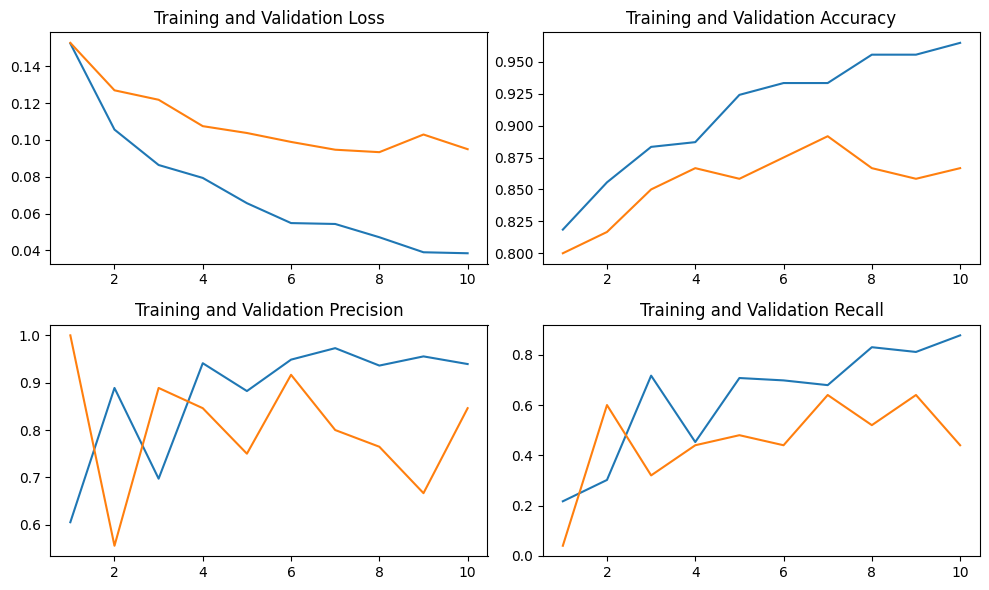

In [ ]:
# Initialize the model
model_rnn_lstm_cls = SentimentClassifierWithSoftAttention(rnn_type='LSTM').to(device)



# Define optimizer and loss function
optimizer = optim.Adam(model_rnn_lstm_cls.parameters(), lr=learning_rate)

model_rnn_lstm_cls = train_model_cls(model_rnn_lstm_cls, optimizer, train_loader, val_loader)

GRU + CLS

Built using GRU
----
Epoch 1, Loss: 0.20370, Training Accuracy: 0.75
               precision    recall  f1-score   support

        toxic       0.45      0.49      0.47        39
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.37      0.31      0.34        32
       threat       0.00      0.00      0.00         0
       insult       0.36      0.28      0.32        32
identity_hate       0.00      0.00      0.00         0

    micro avg       0.36      0.37      0.36       103
    macro avg       0.20      0.18      0.19       103
 weighted avg       0.40      0.37      0.38       103
  samples avg       0.18      0.17      0.16       103


Validation Loss: 0.17323, Validation Accuracy: 0.79
               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00         0
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.00      0.00      0.00         0
       threat       0.00      0.00      0.00     

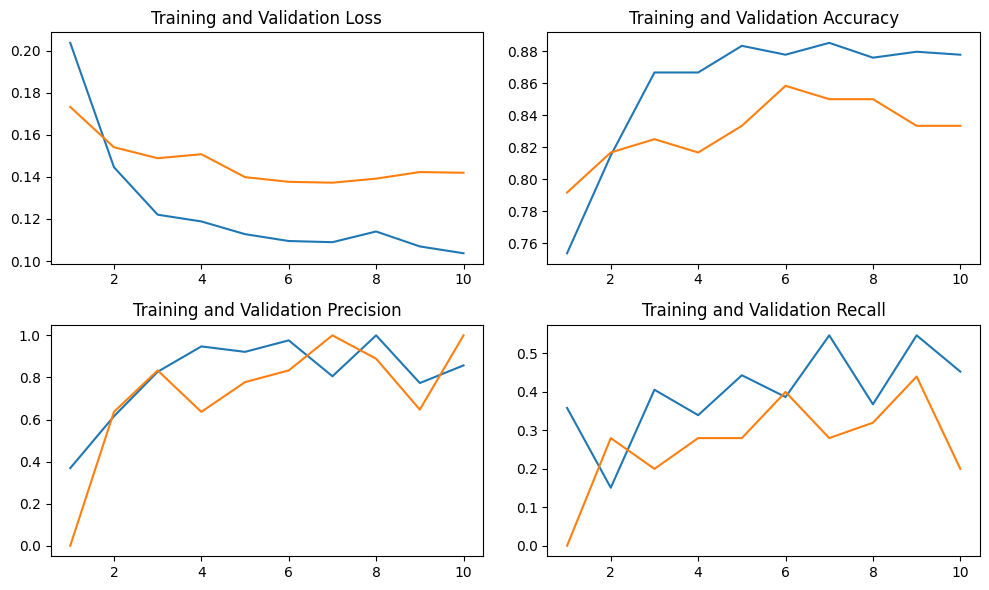

In [ ]:
# Initialize the model
model_rnn_gru_cls = SentimentClassifierWithSoftAttention(rnn_type='GRU').to(device)



# Define optimizer and loss function
optimizer = optim.Adam(model_rnn_gru_cls.parameters(), lr=learning_rate)

model_rnn_gru_cls = train_model_cls(model_rnn_gru_cls, optimizer, train_loader, val_loader)

<h2> Test Phase

In [ ]:
test_loader = DataLoader(custom_test_dataset, batch_size=batch_size, shuffle=True)

# After training, load the best model for test prediction
#best_model = SentimentClassifierWithSoftAttentionWithCLS().to(device)
#best_model.load_state_dict(torch.load('best_model_path'))

def test_without_cls(model_rnn, test_loader):
  model_rnn.eval()

  # Use the best model for prediction on the test set
  test_predictions = []
  target_embeddings = []
  with torch.no_grad():
      for data, targets, _ in test_loader:
          data, targets = data.to(device), targets.to(device) #, cls_tokens.to(device)
          #cls_tokens = cls_tokens.view(cls_tokens.shape[0], 1, cls_tokens.shape[1])

          outputs = model_rnn.forward(data.to(dtype=torch.float32)) #, cls_tokens.to(dtype=torch.float32))
          predictions = torch.round(torch.sigmoid(outputs))
          test_predictions.append(predictions.cpu())
          target_embeddings.append(targets.cpu())

  # Convert test_predictions list to a single numpy array if needed

  predicted_embeddings_np = torch.cat(test_predictions, dim=0).cpu().numpy()
  target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

  metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
  overall_train_accuracy = calculate_accuracy(metrics)

  print("----")
  print(f"Test Accuracy: {overall_train_accuracy:.2f}")
  class_report(target_embeddings_np, predicted_embeddings_np)
  print("")

In [ ]:
def test_with_cls(model_rnn, test_loader):
  model_rnn.eval()

  # Use the best model for prediction on the test set
  test_predictions = []
  target_embeddings = []
  with torch.no_grad():
      for data, targets, cls_tokens in test_loader:
          data, targets, cls_tokens = data.to(device), targets.to(device), cls_tokens.to(device)
          cls_tokens = cls_tokens.view(cls_tokens.shape[0], 1, cls_tokens.shape[1])

          outputs = model_rnn.forward_with_cls(data.to(dtype=torch.float32), cls_tokens.to(dtype=torch.float32))
          predictions = torch.round(torch.sigmoid(outputs))
          test_predictions.append(predictions.cpu())
          target_embeddings.append(targets.cpu())

  # Convert test_predictions list to a single numpy array if needed

  predicted_embeddings_np = torch.cat(test_predictions, dim=0).cpu().numpy()
  target_embeddings_np = torch.cat(target_embeddings, dim=0).cpu().numpy()

  metrics = calculate_metrics(predicted_embeddings_np,target_embeddings_np)
  overall_train_accuracy = calculate_accuracy(metrics)

  print("----")
  print(f"Test Accuracy: {overall_train_accuracy:.2f}")
  class_report(target_embeddings_np, predicted_embeddings_np)
  print("")

In [ ]:
test_without_cls(model_rnn_lstm, test_loader)

----
Test Accuracy: 0.82
               precision    recall  f1-score   support

        toxic       1.00      0.14      0.25        64
 severe_toxic       0.00      0.00      0.00         6
      obscene       0.50      0.12      0.20        24
       threat       0.00      0.00      0.00         6
       insult       0.00      0.00      0.00         0
identity_hate       0.00      0.00      0.00        11

    micro avg       0.63      0.11      0.18       111
    macro avg       0.25      0.04      0.07       111
 weighted avg       0.68      0.11      0.19       111
  samples avg       0.06      0.07      0.06       111




In [ ]:
test_without_cls(model_rnn_gru, test_loader)

----
Test Accuracy: 0.78
               precision    recall  f1-score   support

        toxic       1.00      0.12      0.21        75
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.00      0.00      0.00         0
       threat       0.00      0.00      0.00        18
       insult       0.75      0.09      0.16        33
identity_hate       0.00      0.00      0.00        12

    micro avg       0.63      0.09      0.15       138
    macro avg       0.29      0.04      0.06       138
 weighted avg       0.72      0.09      0.16       138
  samples avg       0.06      0.06      0.06       138




In [ ]:
test_with_cls(model_rnn_lstm_cls, test_loader)

----
Test Accuracy: 0.81
               precision    recall  f1-score   support

        toxic       0.89      0.12      0.21        68
 severe_toxic       0.00      0.00      0.00         1
      obscene       0.33      0.08      0.13        25
       threat       0.00      0.00      0.00         0
       insult       0.25      0.05      0.08        21
identity_hate       0.00      0.00      0.00         0

    micro avg       0.58      0.10      0.16       115
    macro avg       0.25      0.04      0.07       115
 weighted avg       0.64      0.10      0.17       115
  samples avg       0.06      0.06      0.05       115




In [ ]:
test_with_cls(model_rnn_gru_cls, test_loader)

----
Test Accuracy: 0.81
               precision    recall  f1-score   support

        toxic       0.89      0.15      0.25        55
 severe_toxic       0.00      0.00      0.00         8
      obscene       0.00      0.00      0.00         0
       threat       0.00      0.00      0.00         0
       insult       1.00      0.07      0.13        58
identity_hate       0.00      0.00      0.00         0

    micro avg       0.63      0.10      0.17       121
    macro avg       0.31      0.04      0.06       121
 weighted avg       0.88      0.10      0.18       121
  samples avg       0.06      0.06      0.06       121


